In [155]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
from gwaxion import physics
import pandas as pd
import lal

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

In [156]:
reload(physics)

<module 'gwaxion.physics' from '/home/misi/.local/lib/python2.7/site-packages/gwaxion/physics.pyc'>

In [157]:
# scalar timescales (approximate formulas from paper)

def tinst(m, alpha, chi):
    #return 25. * lal.DAYSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**9 / chi
    # The above was incorrect!
    return 27* lal.DAYSID_SI * (m/ (10*lal.MSUN_SI)) * (0.1/alpha)**9 / chi

def tgw(m, alpha, chi):
    #return (6.5E4) * lal.YRSID_SI * (10*lal.MSUN_SI/m) * (0.1/alpha)**15 / chi
    # The above was incorrect!
    return (6.5E4) * lal.YRSID_SI * (m/(10*lal.MSUN_SI)) * (0.1/alpha)**15 / chi


## GW150914-like remnant

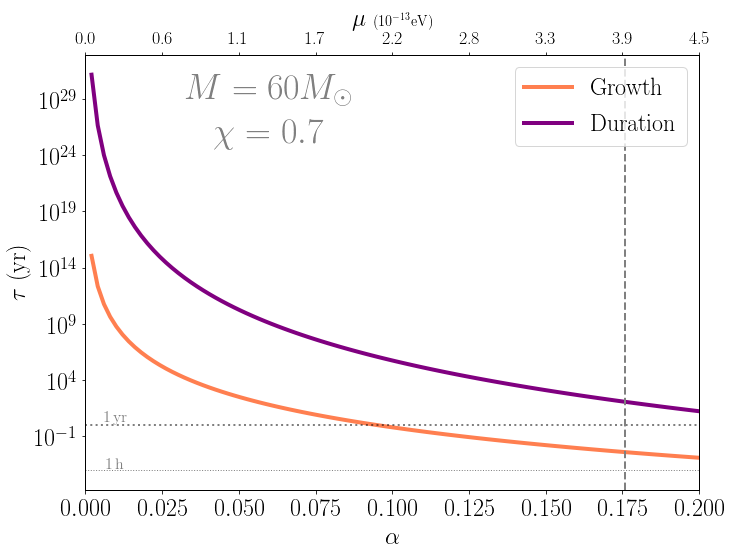

In [158]:
mbh_ex = 60
mbh = mbh_ex*lal.MSUN_SI
chi = 0.7
alphas = np.linspace(0, 0.2, 100)

fig, ax = plt.subplots(1, figsize=(11,8))
ax2 = ax.twiny()

ax.plot(alphas, tinst(mbh, alphas, chi)/lal.YRSID_SI, label='Growth', lw=4, c='coral')
ax.plot(alphas, tgw(mbh, alphas, chi)/lal.YRSID_SI, label='Duration', lw=4, c='purple')

x_text = 0.01
ax.axhline(1, ls=':', c='k', lw=2, alpha=0.5)
ax.text(x_text, 2, r'$1\, $yr',rotation=0, fontsize=16, color='gray', ha='center')

ax.axhline(0.0001, ls=':', c='k', lw=1, alpha=0.5)
ax.text(x_text, 0.0001,r'$1\, $h',rotation=0, fontsize=16, color='gray', ha='center')

# ax.axhline(100, ls=':', c='k', lw=2, alpha=0.5)
# ax.axhline(lal.DAYSID_SI/lal.YRSID_SI, ls=':', c='k', lw=1, alpha=0.5)
ax.axvline(0.176, ls='--', c='gray', lw=2)

ax.set_xlim(0, 0.2)
ax.set_yscale('log')
ax.set_ylabel(r'$\tau$ (yr)')
ax.set_xlabel(r'$\alpha$')

ax.annotate(r'$M=60 M_\odot$'+'\n'+r'$\chi=0.7$', xy=(0.3, 0.95), xycoords="axes fraction", 
            ha='center', va='top', fontsize=36, color='gray')

ax.legend(loc='upper right')

# add boson mass scale
def mu_alpha(alpha):
    return physics.Alpha(alpha=alpha, m_bh=mbh_ex).m_b_ev
mu_ticks = mu_alpha(ax.get_xticks())/1E-13
ax2.set_xticks(mu_ticks)
ax2.set_xticklabels(['%.1f' % x for x in mu_ticks])
ax2.set_xlim(mu_alpha(np.array(ax.get_xlim()))/1E-13)
ax2.set_xlabel(r'$\mu$ {\Large ($10^{-13}$eV)}')
ax2.tick_params(labelsize=18) 

#ax.grid(True)

fig.savefig('plot_tau_alpha.pdf', bbox_inches='tight')

plt.show()
plt.close()

In [159]:
print tinst(mbh, 0.176, chi) / lal.DAYSID_SI
print tgw(mbh, 0.176, chi) / lal.YRSID_SI

1.42824582823
115.684866515


In [160]:
print tinst(mbh, 0.1, chi)/lal.DAYSID_SI
print tgw(mbh, 0.1, chi)/lal.YRSID_SI

231.428571429
557142.857143


Let's compare the above analytic approximation to the expression in the `gwaxion` package.

In [161]:
tinsts_amp = []
tinsts_num = []

for alpha in alphas:
    bhb = physics.BlackHoleBoson.from_parameters(m_bh=mbh_ex, chi_bh=chi, alpha=alpha)
    c = bhb.cloud(1, 1, 0)
    tinsts_amp.append(c.amplitude_growth_time)
    tinsts_num.append(c.number_growth_time)

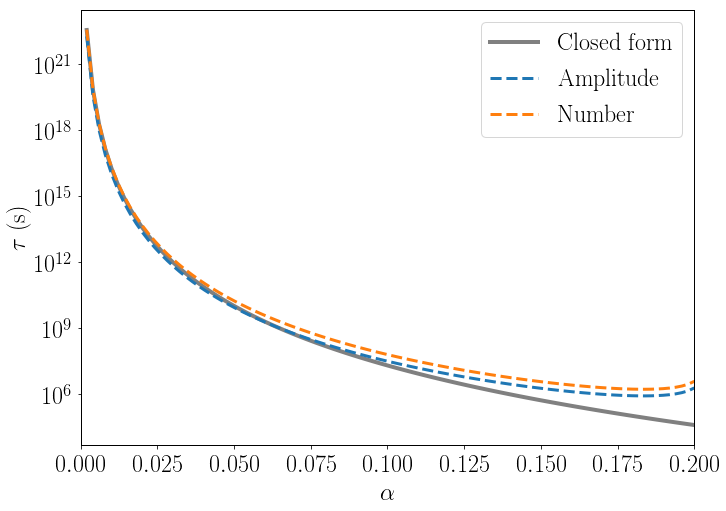

In [162]:
fig, ax = plt.subplots(1, figsize=(11,8))

ax.plot(alphas, tinst(mbh, alphas, chi), label='Closed form', lw=4, c='gray')
ax.plot(alphas, tinsts_amp, label='Amplitude', lw=3, ls='--')
ax.plot(alphas, tinsts_num, label='Number', lw=3, ls='--')

ax.set_xlim(0, 0.2)
ax.set_yscale('log')
ax.set_ylabel(r'$\tau$ (s)')
ax.set_xlabel(r'$\alpha$')

ax.legend(loc='best')

plt.show(fig)

## Mass-spin plane

In [163]:
reload(physics)

<module 'gwaxion.physics' from '/home/misi/.local/lib/python2.7/site-packages/gwaxion/physics.pyc'>

In [164]:
import multiprocessing

n_mass = 100
n_alpha = 100

mbhs_array = np.logspace(0, 3, n_mass)
alphas_array = np.linspace(0.01, 0.2, n_alpha)

a_m_list = []
for a in alphas_array:
    for m in mbhs_array:
        a_m_list.append([a, m])
        
# simple wrapper to get h0, fgw
def get_h0f(a_m):
    alpha, mbh = a_m
    return physics.get_gw_and_times(alpha, m_bh=mbh, chi_bh=0.7, lgw=2, l=1, m=1, nr=0, distance=5E6*physics.PC_SI)

pool = multiprocessing.Pool(8)
h0_f_Ti_list = pool.map(get_h0f, a_m_list)

h0s, fs, Tis = np.array(h0_f_Ti_list).T
alphas, mbhs = np.array(a_m_list).T

In [180]:
# get maximum amplitude per mass
# h0s, fgws = physics.h0_scalar_brito(mbhs_array, alphas_array, chi_i=chi, d=5E6*lal.PC_SI)

df1 = pd.DataFrame({'alpha': alphas, 'mbh': mbhs, 'h0': h0s, 'fgw': fs, 'tinst': Tis})
# df1 = df1[df1['tinst']>0].copy()

grouped = df1.groupby('mbh')
amaxs = []
for mbh in mbhs_array.flatten():
    df_mbh = grouped.get_group(mbh)
    amaxs.append(df_mbh['alpha'][df_mbh['h0']==df_mbh['h0'].max()].iloc[0])

In [181]:
physics.get_alpha_max(0.7)

0.2041836836755107

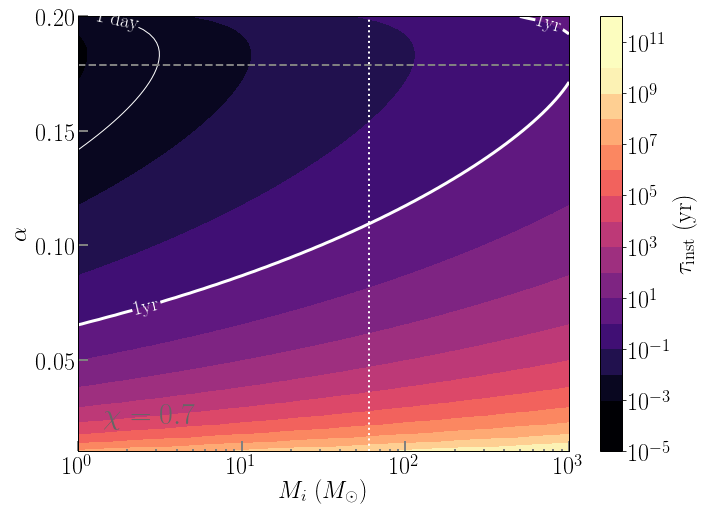

In [183]:
#tinsts = tinst(mbhs*lal.MSUN_SI, alphas, chi)/lal.YRSID_SI

# from matplotlib.mlab import griddata
# tinsts = griddata(df1['mbh'], df1['alpha'], df1['tinst'] / physics.YRSID_SI, mbhs_array, alphas_array, interp='linear')
# no need for the above because we already have a grid

X = df1['mbh'].reshape(n_alpha, n_mass)
Y = df1['alpha'].reshape(n_alpha, n_mass)
Z = df1['tinst'].reshape(n_alpha, n_mass) / lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=Z.min(), vmax=Z.max())

fig, ax = plt.subplots(1, figsize=(11,8))
ax.set_xscale('log')

cm = ax.contourf(X, Y, Z, cmap='magma', locator=ticker.LogLocator(numticks=18,base=10), norm=norm)

cs = ax.contour(X, Y, Z, levels = [lal.DAYSID_SI/lal.YRSID_SI,1], colors=('white',), linestyles=('-','-'), 
                linewidths=(1,3))

strs = ['1 day', '1yr']
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

#cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm inst}$ (yr)')#, ticks=cb_ticks)

ax.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)

ax.axvline(mbh_ex, ls=':', c='w', lw=2)

yticks = np.arange(0, 0.25, 0.05)[1:]
ax.set_yticks(yticks)


ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$M_i$ $(M_\odot)$')

ax.tick_params(axis='both', color='0.5', which='both', width=2, direction='in')
ax.tick_params(axis='both', color='0.5', length=10, direction='in')

ax.annotate(r'$\chi=0.7$', xy=(0.05, 0.05), xycoords="axes fraction", 
            ha='left', va='bottom', fontsize=30, color='0.4')

fig.savefig('cmap_alpha_mbh_tinst.pdf', bbox_inches='tight')

plt.show()
plt.close()

In [177]:
# THE CODE BELOW WORKS, but requires more samples

# norm = matplotlib.colors.LogNorm(vmin=tinsts.min(), vmax=tinsts.max())

# fig, ax = plt.subplots(1, figsize=(11,8))

# cm = ax.hexbin(df1['mbh'], df1['alpha'], df1['tinst']/ lal.YRSID_SI, cmap='magma', norm=norm, xscale='log')

# ax.set_xscale('log')

# cs = ax.contour(X, Y, Z, levels = [0.0001,1], colors=('white',),linestyles=('-','-'), linewidths=(1,3))

# strs = ['1 h', '1 yr']
# fmt = {l: s for l, s in zip(cs.levels, strs)}
# plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

# #cb_ticks = np.logspace(-30, -24, 7)# np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
# cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm inst}$ (yr)')#, ticks=cb_ticks)

# ax.plot(mbhs_array.flatten(), amaxs, '--', color='gray', lw=2)

# ax.axvline(mbh_ex, ls=':', c='w', lw=2)

# yticks = np.arange(0, 0.25, 0.05)[1:]
# ax.set_yticks(yticks)

# ax.set_xscale('log')
# ax.set_ylabel(r'$\alpha$')
# ax.set_xlabel(r'$M$ $(M_\odot)$')

# ax.tick_params(axis='both', color='0.5', which='both', width=2, direction='in')
# ax.tick_params(axis='both', color='0.5', length=10, direction='in')

# ax.annotate(r'$\chi=0.7$', xy=(0.05, 0.05), xycoords="axes fraction", 
#             ha='left', va='bottom', fontsize=30, color='0.5')

# #fig.savefig('cmap_alpha_mbh_tinst.pdf', bbox_inches='tight')

# plt.show()
# plt.close()

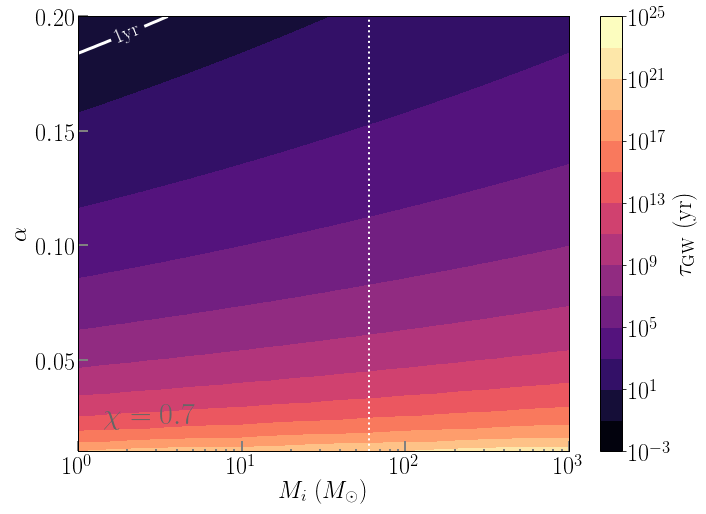

In [186]:
X = mbhs.reshape(n_alpha, n_mass)
Y = alphas.reshape(n_alpha, n_mass)

tgws = tgw(X*lal.MSUN_SI, Y, chi)

Z = tgws/lal.YRSID_SI

norm = matplotlib.colors.LogNorm(vmin=1E-2, vmax=1E24)

fig, ax = plt.subplots(1, figsize=(11,8))
ax.set_xscale('log')

cm = ax.contourf(X, Y, Z, cmap='magma', norm=norm, locator=ticker.LogLocator(numticks=18,base=10), )
cb = plt.colorbar(cm, norm=norm, label=r'$\tau_{\rm GW}$ (yr)')#, ticks=cb_ticks)

cs = ax.contour(X, Y, Z, levels = [0.0001,1], colors=('white',),linestyles=('-','-'), linewidths=(3,))
ax.axvline(mbh_ex, ls=':', c='w', lw=2)

strs = ['1yr', '1 yr']
fmt = {l: s for l, s in zip(cs.levels, strs)}
plt.clabel(cs, cs.levels[::1], inline=True, fmt=fmt, fontsize=20)

ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$M_i$ $(M_\odot)$')

yticks = np.arange(0, 0.25, 0.05)[1:]
ax.set_yticks(yticks)

ax.tick_params(axis='both', color='0.5', which='both', width=2, direction='in')
ax.tick_params(axis='both', color='0.5', length=10, direction='in')

ax.annotate(r'$\chi=0.7$', xy=(0.05, 0.05), xycoords="axes fraction", 
            ha='left', va='bottom', fontsize=30, color='0.4')

fig.savefig('cmap_alpha_mbh_tgw.pdf', bbox_inches='tight')

plt.show()
plt.close()

In [179]:
# make plot of region for which t_inst < 1yr < t_gw

df1['tinst'] = tinsts.flatten()
df1['tgw'] = tgws.flatten()